# Linear Variational Auto Encoder
This notebook demonstrates the training of a Linear Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses, with BCE loss for reconstruction.

In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 56829.11it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 11.72it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:03<00:00,  8.94it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:04<00:00,  7.62it/s]



Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:26<00:00,  1.30it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:03<00:00,  9.21it/s]


NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 5
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_4954/3740862327.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['EC-Earth3', 'E3SM-2-0', 'GISS-E2-1-G', 'ACCESS-ESM1-5']
Testing model: GISS-E2-2-G


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 26.09it/s]

Data normalization completed.


Flattened the data


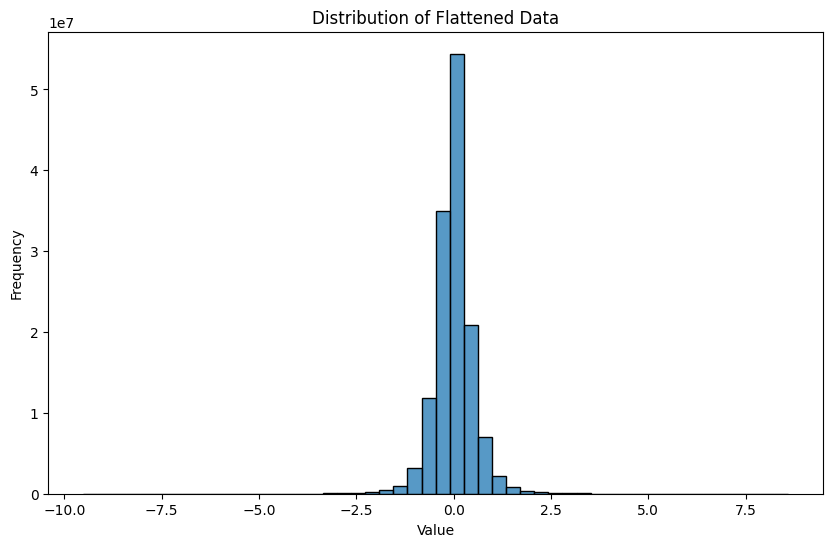

In [7]:
# Print the distribution of the data
# Flatten the data for analysis
flattened_data = np.concatenate([np.ravel(array) for model in normalized_train_data.values() for array in model.values()])
print("Flattened the data")
# Plot the distribution of the data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_data, bins=50, kde=False)
plt.title('Distribution of Flattened Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

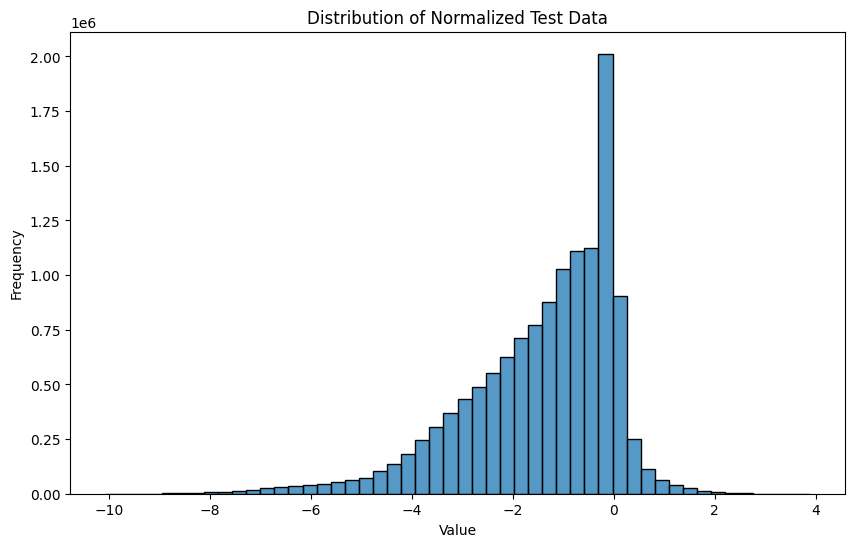

In [8]:
# Flatten the normalized_test_data for analysis
flattened_test_data = np.concatenate([np.ravel(array) for model in normalized_test_data.values() for array in model.values()])

# Plot the distribution of the flattened normalized_test_data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_test_data, bins=50, kde=False)
plt.title('Distribution of Normalized Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Create dataset for the linear VAE
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
batch_size = 16  # Higher batch size for linear VAE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Check the shape of the data
sample = next(iter(train_loader))
print(f"Input shape: {sample['input'].shape}")
print(f"Output shape: {sample['output'].shape}")

Creating datasets...


Processing models: 100%|██████████| 4/4 [00:00<00:00, 47127.01it/s]
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


Training dataset size: 124
Testing dataset size: 11
Input shape: torch.Size([16, 165, 6523])
Output shape: torch.Size([16, 165, 6523])
Input shape: torch.Size([16, 165, 6523])
Output shape: torch.Size([16, 165, 6523])


In [10]:
# Initialize the Linear VAE model
# Calculate input dimension from flattened sample
sample = next(iter(train_loader))
input_shape = sample['input'].shape[1:]
print(input_shape)
input_dim = np.prod(input_shape)
print(f"Input dimension for VAE: {input_dim}")

# Set VAE parameters
hidden_dim = 128  # Increased for better representation
latent_dim = 64   # Intermediate layer size
z_dim = 50       # Actual latent space dimension
# beta = 0.001      # Weight for KL divergence term -- not used in this version

# Create the model
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device).to(device)

# Apply weight initialization
# vae_model.apply(initialize_weights)

# Define optimizer with weight decay for regularization
optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-4) # Weight decay is not used in this version (was weight_decay=1e-5)

# Print model summary
print("\nLinear VAE Model Architecture:")
print(vae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")

torch.Size([165, 6523])
Input dimension for VAE: 1076295

Linear VAE Model Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1076295, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=64, out_features=5, bias=True)
  (var_layer): Linear(in_features=64, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

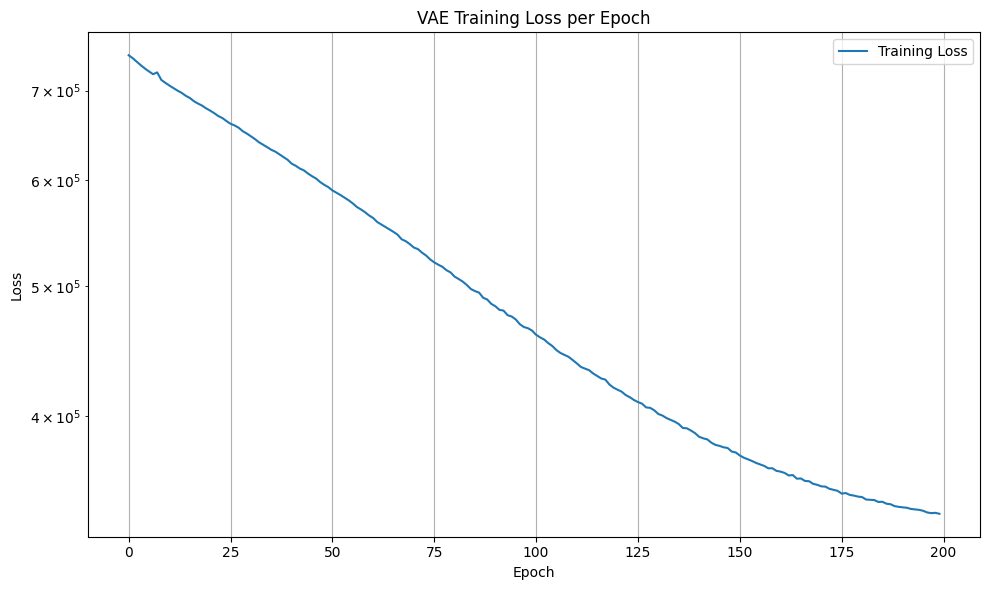

Final loss value: 3.38e+05


In [ ]:
# Define custom loss function with BCE instead of MSE
def custom_vae_loss(x, x_hat, mean, logvar, beta=0.001):
    # Scale input data to [0, 1] range for BCE loss
    x_scaled = (x + 1) / 2.0
    x_hat_scaled = (x_hat + 1) / 2.0
    
    # BCE loss for reconstruction error
    recon_loss = F.binary_cross_entropy(x_hat_scaled, x_scaled, reduction='sum')
    
    # KL divergence term
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    # Total loss
    return recon_loss + beta * kl_loss

# Train the VAE
epochs = 100
losses = []

vae_model.train()
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for batch in train_loader:
        # Get the input and target data
        x = batch['input'].view(batch['input'].size(0), -1).to(device)  # Flatten input
        y = batch['output'].view(batch['output'].size(0), -1).to(device)  # Flatten target
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_hat, mean, logvar = vae_model(x)
        
        # Compute loss using the custom BCE+KL loss function
        loss = custom_vae_loss(y, y_hat, mean, logvar, beta=beta)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Calculate average loss for this epoch
    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

In [ ]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

torch.Size([8, 1076295])
torch.Size([3, 1076295])
Average test loss: 1.06e+06


In [ ]:
# Evaluate VAE and generate animations
vae_model.eval()  # Set the model to evaluation mode

# Get the raw test data for one model example
example_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[example_model].keys() if run != 'forced_response']
ground_truth = normalized_test_data[example_model]['forced_response']

# Set the number of test runs to visualize
num_runs = min(3, len(test_runs))

# Create a figure to show the animations
from IPython.display import display, HTML

# Find min/max values for consistent color limits
all_data = []
for run in test_runs[:num_runs]:
    all_data.append(normalized_test_data[example_model][run])
all_data.append(ground_truth)
all_data = np.concatenate(all_data)
vmin, vmax = np.nanmin(all_data), np.nanmax(all_data)
color_limits = (vmin, vmax)
print(f"Color limits: {vmin:.4f}, {vmax:.4f}")

# Process each test run
for counter, run in enumerate(test_runs[:num_runs]):
    print(f"\nProcessing run {counter+1}/{num_runs}...")
    
    # Get the test run data
    test_run = normalized_test_data[example_model][run]
    original_shape = test_run.shape
    
    # Flatten and convert to tensor
    x_test = torch.tensor(test_run.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
    
    # Generate reconstruction using VAE
    with torch.no_grad():
        reconstruction, _, _ = vae_model(x_test)
    
    # Convert back to numpy and reshape to original dimensions
    prediction = reconstruction.cpu().squeeze(0).numpy().reshape(original_shape)
    
    # Re-add NaN values to the data matrices
    prediction = readd_nans_to_grid(prediction, nan_mask, predictions=True)
    test_run_with_nans = readd_nans_to_grid(test_run, nan_mask, predictions=True)
    ground_truth_with_nans = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
    
    # Calculate MSE
    test_mse = calculate_mse(test_run, None, ground_truth)
    pred_mse = calculate_mse(prediction, None, ground_truth)
    
    print(f"Input MSE: {test_mse:.4f}")
    print(f"Prediction MSE: {pred_mse:.4f}")
    
    # Create animations
    pred_animation = animate_data(
        prediction,
        title=f'VAE Reconstruction (BCE): {example_model} - {run} (MSE: {pred_mse:.4f})',
        interval=200,
        cmap='viridis',
        color_limits=color_limits
    )
    
    input_animation = animate_data(
        test_run_with_nans,
        title=f'Input: {example_model} - {run} (MSE: {test_mse:.4f})',
        interval=200,
        cmap='viridis',
        color_limits=color_limits
    )
    
    ground_truth_animation = animate_data(
        ground_truth_with_nans,
        title=f'Ground Truth: {example_model}',
        interval=200,
        cmap='viridis',
        color_limits=color_limits
    )
    
    # Display the animations
    print(f"\nRun {counter+1} - Input:")
    display(HTML(input_animation.to_html5_video()))
    
    print(f"\nRun {counter+1} - Ground Truth:")
    display(HTML(ground_truth_animation.to_html5_video()))
    
    print(f"\nRun {counter+1} - VAE Reconstruction:")
    display(HTML(pred_animation.to_html5_video()))